<a href="https://colab.research.google.com/github/t4n15hq/luminari/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from google.colab import drive
import traceback
from collections import Counter
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
class Config:
    def __init__(self):
        self.base_path = '/content/drive/MyDrive/dataset/SkinDisease'
        self.train_dir = os.path.join(self.base_path, 'train')
        self.test_dir = os.path.join(self.base_path, 'test')
        self.processed_dir = os.path.join(self.base_path, 'processed_data')
        self.image_size = (224,224)
        self.batch_size = 32
        self.valid_extensions = {'.jpg', '.jpeg', '.png'}
        self.use_mixed_precision = True
        # Added class-specific parameters
        self.min_class_size = 212  # From your distribution
        self.max_class_size = 1405  # From your distribution
        self.target_percentile = 75  # For balanced target size calculation

    def create_directories(self):
        """Create necessary directories"""
        os.makedirs(self.processed_dir, exist_ok=True)
        os.makedirs(os.path.join(self.processed_dir, 'train_balanced'), exist_ok=True)
        os.makedirs(os.path.join(self.processed_dir, 'test'), exist_ok=True)
        print(f"Created directories in: {self.processed_dir}")

In [17]:
class ImageProcessor:
   def __init__(self, config):
       self.config = config
       self.augmenter = None  # Will be set dynamically based on class

   def normalize_image(self, image):
       """Normalize image with contrast enhancement"""
       mean = np.mean(image)
       std = np.std(image)
       normalized = (image - mean) / (std + 1e-7)
       return np.clip(normalized, -3, 3)

   def get_balanced_target_size(self, class_sizes):
       """Calculate optimal target size for balancing"""
       total_samples = sum(class_sizes.values())
       n_classes = len(class_sizes)

       # Use 75th percentile instead of max to avoid extreme augmentation
       target_size = int(np.percentile(list(class_sizes.values()), 75))

       print(f"Balancing Statistics:")
       print(f"Current min size: {min(class_sizes.values())}")
       print(f"Current max size: {max(class_sizes.values())}")
       print(f"Target size: {target_size}")

       return target_size

   def setup_augmenter(self, current_size, target_size):
       """Setup augmentation based on class size difference"""
       params = self.get_augmentation_params(current_size, target_size)
       return ImageDataGenerator(
           rotation_range=params['rotation_range'],
           width_shift_range=params['width_shift_range'],
           height_shift_range=params['height_shift_range'],
           zoom_range=params['zoom_range'],
           horizontal_flip=params['horizontal_flip'],
           vertical_flip=params['vertical_flip'],
           brightness_range=params['brightness_range'],
           fill_mode='nearest'
       )

   def get_augmentation_params(self, current_size, target_size):
       """Get adaptive augmentation parameters based on class size difference"""
       size_ratio = current_size / target_size

       if size_ratio < 0.3:  # Severe underrepresentation
           return {
               'rotation_range': 30,
               'width_shift_range': 0.3,
               'height_shift_range': 0.3,
               'zoom_range': 0.3,
               'horizontal_flip': True,
               'vertical_flip': False,
               'brightness_range': [0.6, 1.4],
               'mixup_ratio': 0.4
           }
       elif size_ratio < 0.6:  # Moderate underrepresentation
           return {
               'rotation_range': 20,
               'width_shift_range': 0.2,
               'height_shift_range': 0.2,
               'zoom_range': 0.2,
               'horizontal_flip': True,
               'vertical_flip': False,
               'brightness_range': [0.7, 1.3],
               'mixup_ratio': 0.3
           }
       else:  # Mild underrepresentation
           return {
               'rotation_range': 15,
               'width_shift_range': 0.15,
               'height_shift_range': 0.15,
               'zoom_range': 0.15,
               'horizontal_flip': True,
               'vertical_flip': False,
               'brightness_range': [0.8, 1.2],
               'mixup_ratio': 0.2
           }

   def process_class(self, class_path, class_name):
       """Enhanced image processing with size optimization"""
       images = []
       image_files = [f for f in os.listdir(class_path)
                     if f.lower().endswith(tuple(self.config.valid_extensions))]

       for img_name in tqdm(image_files, desc=f"Processing {class_name}"):
           img_path = os.path.join(class_path, img_name)
           try:
               image = cv2.imread(img_path)
               if image is not None:
                   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                   image = cv2.resize(image, self.config.image_size)
                   image = self.process_with_specialization(image, class_name)
                   image = self.normalize_image(image)
                   image = preprocess_input(image)
                   image = image.astype(np.float16)  # Convert to float16
                   images.append(image)
           except Exception as e:
               print(f"Error processing {img_path}: {str(e)}")

       return np.array(images, dtype=np.float16)

   def augment_class(self, class_images, target_size):
       """Improved augmentation strategy with mixup"""
       current_size = len(class_images)
       if current_size >= target_size:
           return class_images[:target_size]

       augmented_images = []
       samples_needed = target_size - current_size

       # Get augmentation parameters including mixup ratio
       params = self.get_augmentation_params(current_size, target_size)
       mixup_samples = int(samples_needed * params['mixup_ratio'])
       regular_samples = samples_needed - mixup_samples

       # Regular augmentation
       for _ in range(regular_samples):
           idx = np.random.randint(0, current_size)
           img = class_images[idx]
           img_batch = np.expand_dims(img, 0)
           aug_iter = self.augmenter.flow(img_batch, batch_size=1)
           aug_img = next(aug_iter)[0].astype(np.float16)
           augmented_images.append(aug_img)

           if len(augmented_images) % 100 == 0:
               gc.collect()

       # Mixup augmentation
       for _ in range(mixup_samples):
           idx1, idx2 = np.random.randint(0, current_size, 2)
           img1, img2 = class_images[idx1], class_images[idx2]
           lam = np.random.beta(0.2, 0.2)
           mixed_img = (lam * img1 + (1 - lam) * img2).astype(np.float16)
           augmented_images.append(mixed_img)

       return np.concatenate([class_images, np.array(augmented_images, dtype=np.float16)])

   def process_with_specialization(self, image, class_name):
       """Apply specialized preprocessing based on skin condition type"""
       params = self.get_specialized_preprocessing(class_name)

       if params.get('contrast_enhancement'):
           image = self.enhance_contrast(image)

       if params.get('color_normalization'):
           image = self.normalize_color(image)

       if params.get('texture_enhancement'):
           image = self.enhance_texture(image)

       if params.get('red_channel_enhancement'):
           image = self.enhance_red_channel(image)

       return image

   def enhance_contrast(self, image):
       """Enhanced contrast normalization for better feature visibility"""
       lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
       l, a, b = cv2.split(lab)
       clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
       cl = clahe.apply(l)
       enhanced = cv2.merge((cl,a,b))
       return cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

   def normalize_color(self, image):
       """Color normalization for consistent color representation"""
       norm_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
       return norm_image

   def enhance_texture(self, image):
       """Texture enhancement for conditions where texture is important"""
       gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
       enhanced = cv2.equalizeHist(gray)
       return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

   def enhance_red_channel(self, image):
       """Red channel enhancement for conditions with redness"""
       r, g, b = cv2.split(image)
       r = cv2.equalizeHist(r)
       return cv2.merge([r, g, b])

   def get_specialized_preprocessing(self, class_name):
       """Get specialized preprocessing parameters for different skin conditions"""
       specialized_params = {
           'Melanoma Skin Cancer Nevi and Moles': {
               'contrast_enhancement': True,
               'color_normalization': True
           },
           'Psoriasis pictures Lichen Planus and related diseases': {
               'texture_enhancement': True
           },
           'Acne and Rosacea Photos': {
               'red_channel_enhancement': True
           },
           'Cellulitis Impetigo and other Bacterial Infections': {
               'red_channel_enhancement': True,
               'contrast_enhancement': True
           },
           'Vasculitis Photos': {
               'red_channel_enhancement': True,
               'contrast_enhancement': True
           },
           'Light Diseases and Disorders of Pigmentation': {
               'color_normalization': True,
               'contrast_enhancement': True
           }
       }

       return specialized_params.get(class_name, {})

   def process_and_save(self, input_dir, output_dir, balance=False):
    """Process and save data class by class with improved balancing"""
    class_dirs = sorted([d for d in os.listdir(input_dir)
                       if os.path.isdir(os.path.join(input_dir, d))])

    print(f"\nProcessing directory: {input_dir}")
    print(f"Found {len(class_dirs)} classes")

    if balance:
        class_sizes = {class_name: len([
            f for f in os.listdir(os.path.join(input_dir, class_name))
            if f.lower().endswith(tuple(self.config.valid_extensions))
        ]) for class_name in class_dirs}

        target_size = self.get_balanced_target_size(class_sizes)
        print(f"Balanced target size per class: {target_size}")

    for class_name in class_dirs:
        try:
            class_path = os.path.join(input_dir, class_name)
            print(f"\nProcessing class: {class_name}")

            class_images = self.process_class(class_path, class_name)
            print(f"Processed {len(class_images)} images")

            if balance:
                current_size = len(class_images)
                if current_size < target_size:
                    print(f"Augmenting {class_name}: {current_size} -> {target_size}")
                    self.augmenter = self.setup_augmenter(current_size, target_size)
                    class_images = self.augment_class(class_images, target_size)

            # Change extension to .npz for compressed files
            save_path = os.path.join(output_dir, f'{class_name}.npz')
            np.savez_compressed(save_path, data=class_images)

            # Check file size after ensuring file exists
            if os.path.exists(save_path):
                print(f"Saved to: {save_path}")
                print(f"File size: {os.path.getsize(save_path) / (1024*1024):.2f} MB")
            else:
                print(f"Warning: File not saved properly to {save_path}")

            gc.collect()

        except Exception as e:
            print(f"Error processing class {class_name}: {str(e)}")
            traceback.print_exc()

In [18]:
def validate_class_balance(config):
    """Validate the class balance after preprocessing"""
    train_dir = os.path.join(config.processed_dir, 'train_balanced')
    class_sizes = {}

    print("\nValidating class balance...")
    for file in os.listdir(train_dir):
        if file.endswith('.npy'):
            data = np.load(os.path.join(train_dir, file))
            class_sizes[file] = len(data)
            print(f"{file}: {len(data)} samples")

    plt.figure(figsize=(15, 5))
    plt.bar(class_sizes.keys(), class_sizes.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Processed Data Class Distribution')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

    print("\nProcessed Data Statistics:")
    print(f"Max class size: {max(class_sizes.values())}")
    print(f"Min class size: {min(class_sizes.values())}")
    print(f"Mean class size: {np.mean(list(class_sizes.values())):.2f}")
    print(f"Median class size: {np.median(list(class_sizes.values()))}")

In [19]:
def get_class_distribution(base_path):
    """Analyze class distribution"""
    class_distribution = {}
    class_dirs = sorted([d for d in os.listdir(base_path)
                        if os.path.isdir(os.path.join(base_path, d))])

    for class_name in class_dirs:
        class_path = os.path.join(base_path, class_name)
        num_images = len([f for f in os.listdir(class_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_distribution[class_name] = num_images

    return class_distribution

def plot_class_distributions(train_dir, test_dir, figsize=(15, 10)):
    """Plot class distributions"""
    train_dist = get_class_distribution(train_dir)
    test_dist = get_class_distribution(test_dir)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    train_items = sorted(train_dist.items(), key=lambda x: x[1], reverse=True)
    classes, train_counts = zip(*train_items)
    test_counts = [test_dist[c] for c in classes]

    sns.barplot(x=train_counts, y=classes, ax=ax1, orient='h', color='skyblue')
    ax1.set_title('Training Set Class Distribution')
    ax1.set_xlabel('Number of Samples')

    sns.barplot(x=test_counts, y=classes, ax=ax2, orient='h', color='lightgreen')
    ax2.set_title('Test Set Class Distribution')
    ax2.set_xlabel('Number of Samples')

    plt.tight_layout()
    plt.show()

    print("\nClass Distribution Statistics:")
    print("\nTraining Set:")
    for c in classes:
        print(f"{c}: {train_dist[c]}")
    print(f"\nTotal training samples: {sum(train_dist.values())}")
    print(f"Max class size (train): {max(train_dist.values())}")
    print(f"Min class size (train): {min(train_dist.values())}")

    print("\nTest Set:")
    for c in classes:
        print(f"{c}: {test_dist[c]}")
    print(f"\nTotal test samples: {sum(test_dist.values())}")
    print(f"Max class size (test): {max(test_dist.values())}")
    print(f"Min class size (test): {min(test_dist.values())}")

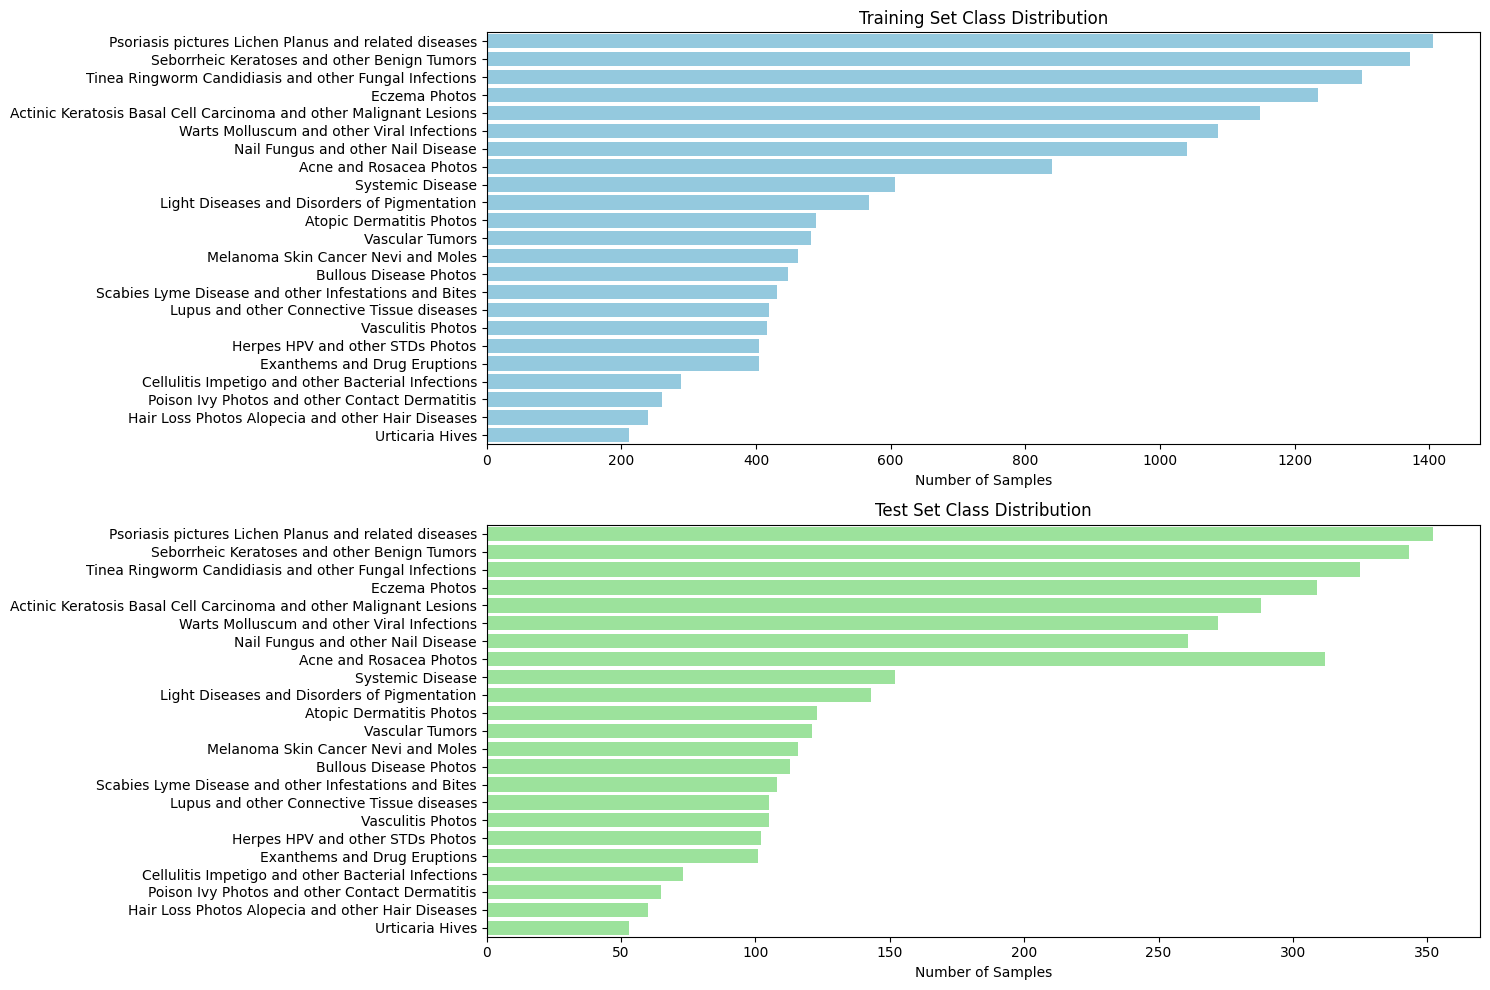


Class Distribution Statistics:

Training Set:
Psoriasis pictures Lichen Planus and related diseases: 1405
Seborrheic Keratoses and other Benign Tumors: 1371
Tinea Ringworm Candidiasis and other Fungal Infections: 1300
Eczema Photos: 1235
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 1149
Warts Molluscum and other Viral Infections: 1086
Nail Fungus and other Nail Disease: 1040
Acne and Rosacea Photos: 840
Systemic Disease: 606
Light Diseases and Disorders of Pigmentation: 568
Atopic Dermatitis Photos: 489
Vascular Tumors: 482
Melanoma Skin Cancer Nevi and Moles: 463
Bullous Disease Photos: 448
Scabies Lyme Disease and other Infestations and Bites: 431
Lupus and other Connective Tissue diseases: 420
Vasculitis Photos: 416
Herpes HPV and other STDs Photos: 405
Exanthems and Drug Eruptions: 404
Cellulitis Impetigo and other Bacterial Infections: 288
Poison Ivy Photos and other Contact Dermatitis: 260
Hair Loss Photos Alopecia and other Hair Diseases: 239
Urticaria Hi

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

def get_class_distribution(base_path):
    class_distribution = {}

    # Get all subdirectories (classes)
    class_dirs = sorted([d for d in os.listdir(base_path)
                        if os.path.isdir(os.path.join(base_path, d))])

    for class_name in class_dirs:
        class_path = os.path.join(base_path, class_name)
        # Count images in each class directory
        num_images = len([f for f in os.listdir(class_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_distribution[class_name] = num_images

    return class_distribution

def plot_class_distributions(train_dir, test_dir, figsize=(15, 10)):
    # Get distributions
    train_dist = get_class_distribution(train_dir)
    test_dist = get_class_distribution(test_dir)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Sort by number of samples
    train_items = sorted(train_dist.items(), key=lambda x: x[1], reverse=True)
    classes, train_counts = zip(*train_items)
    test_counts = [test_dist[c] for c in classes]

    # Plot training distribution
    sns.barplot(x=train_counts, y=classes, ax=ax1, orient='h', color='skyblue')
    ax1.set_title('Training Set Class Distribution')
    ax1.set_xlabel('Number of Samples')

    # Plot test distribution
    sns.barplot(x=test_counts, y=classes, ax=ax2, orient='h', color='lightgreen')
    ax2.set_title('Test Set Class Distribution')
    ax2.set_xlabel('Number of Samples')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nClass Distribution Statistics:")
    print("\nTraining Set:")
    for c in classes:
        print(f"{c}: {train_dist[c]}")
    print(f"\nTotal training samples: {sum(train_dist.values())}")
    print(f"Max class size (train): {max(train_dist.values())}")
    print(f"Min class size (train): {min(train_dist.values())}")

    print("\nTest Set:")
    for c in classes:
        print(f"{c}: {test_dist[c]}")
    print(f"\nTotal test samples: {sum(test_dist.values())}")
    print(f"Max class size (test): {max(test_dist.values())}")
    print(f"Min class size (test): {min(test_dist.values())}")

# Usage
train_dir = '/content/drive/MyDrive/dataset/SkinDisease/train'
test_dir = '/content/drive/MyDrive/dataset/SkinDisease/test'
plot_class_distributions(train_dir, test_dir)

Starting enhanced preprocessing pipeline...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created directories in: /content/drive/MyDrive/dataset/SkinDisease/processed_data

Analyzing initial class distribution...


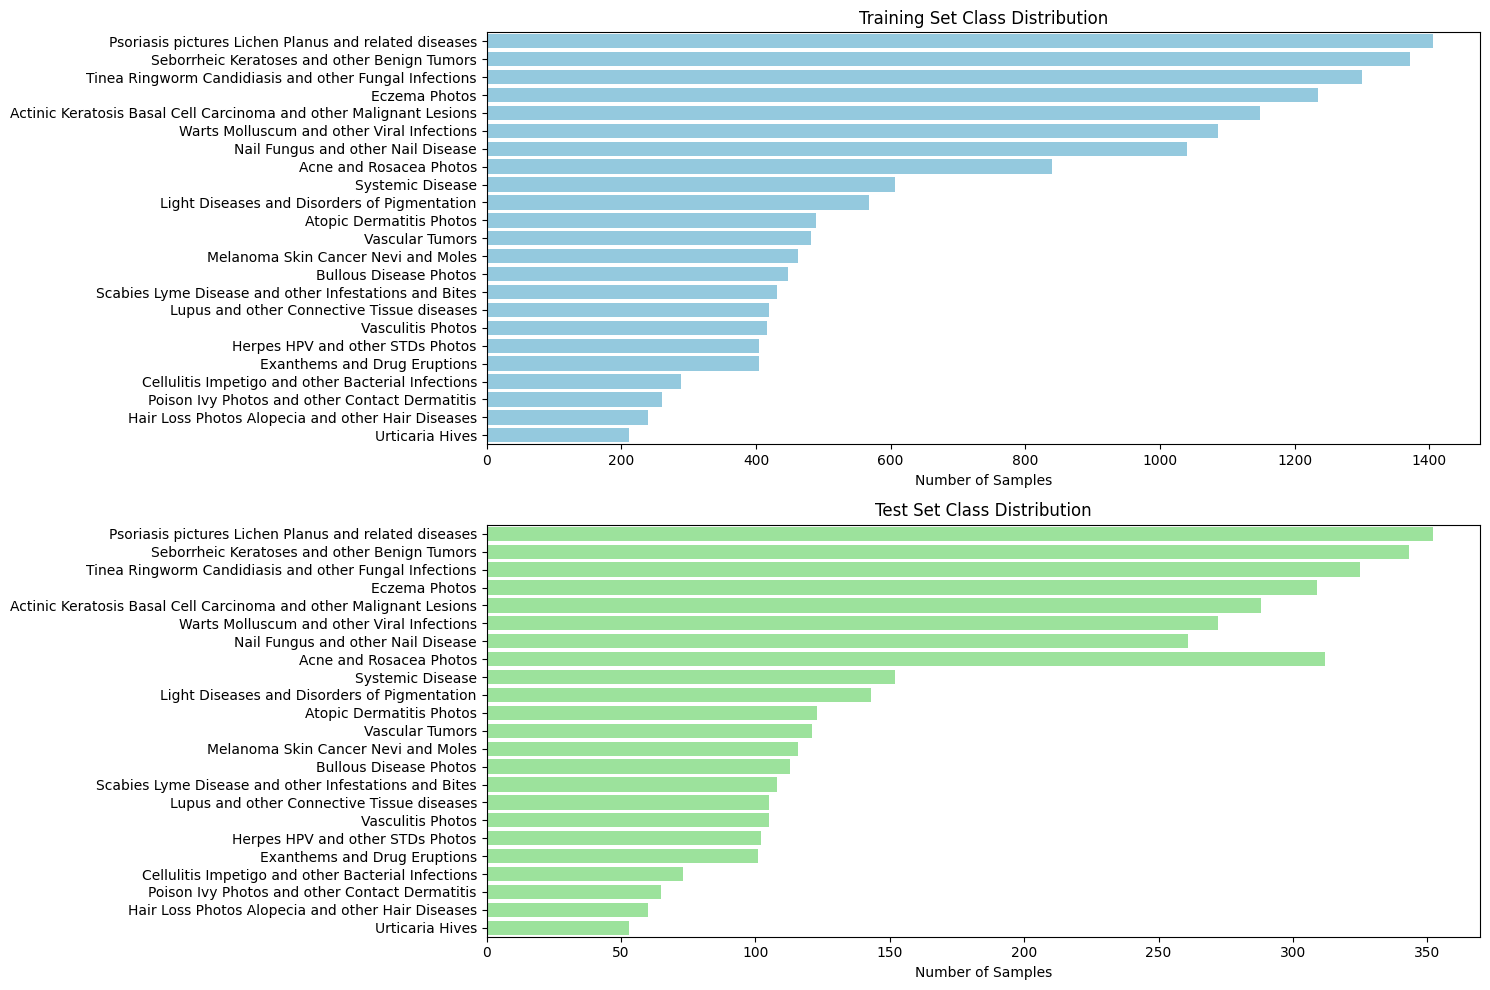


Class Distribution Statistics:

Training Set:
Psoriasis pictures Lichen Planus and related diseases: 1405
Seborrheic Keratoses and other Benign Tumors: 1371
Tinea Ringworm Candidiasis and other Fungal Infections: 1300
Eczema Photos: 1235
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 1149
Warts Molluscum and other Viral Infections: 1086
Nail Fungus and other Nail Disease: 1040
Acne and Rosacea Photos: 840
Systemic Disease: 606
Light Diseases and Disorders of Pigmentation: 568
Atopic Dermatitis Photos: 489
Vascular Tumors: 482
Melanoma Skin Cancer Nevi and Moles: 463
Bullous Disease Photos: 448
Scabies Lyme Disease and other Infestations and Bites: 431
Lupus and other Connective Tissue diseases: 420
Vasculitis Photos: 416
Herpes HPV and other STDs Photos: 405
Exanthems and Drug Eruptions: 404
Cellulitis Impetigo and other Bacterial Infections: 288
Poison Ivy Photos and other Contact Dermatitis: 260
Hair Loss Photos Alopecia and other Hair Diseases: 239
Urticaria Hi

Processing Acne and Rosacea Photos: 100%|██████████| 840/840 [00:07<00:00, 113.94it/s]


Processed 840 images
Augmenting Acne and Rosacea Photos: 840 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Acne and Rosacea Photos.npz
File size: 154.67 MB

Processing class: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions


Processing Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 100%|██████████| 1149/1149 [00:18<00:00, 63.40it/s] 


Processed 1149 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions.npz
File size: 171.77 MB

Processing class: Atopic Dermatitis Photos


Processing Atopic Dermatitis Photos: 100%|██████████| 489/489 [00:05<00:00, 87.49it/s] 


Processed 489 images
Augmenting Atopic Dermatitis Photos: 489 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Atopic Dermatitis Photos.npz
File size: 149.59 MB

Processing class: Bullous Disease Photos


Processing Bullous Disease Photos: 100%|██████████| 448/448 [00:04<00:00, 91.98it/s] 


Processed 448 images
Augmenting Bullous Disease Photos: 448 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Bullous Disease Photos.npz
File size: 160.83 MB

Processing class: Cellulitis Impetigo and other Bacterial Infections


Processing Cellulitis Impetigo and other Bacterial Infections: 100%|██████████| 288/288 [00:03<00:00, 84.46it/s]


Processed 288 images
Augmenting Cellulitis Impetigo and other Bacterial Infections: 288 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Cellulitis Impetigo and other Bacterial Infections.npz
File size: 176.77 MB

Processing class: Eczema Photos


Processing Eczema Photos: 100%|██████████| 1235/1235 [00:18<00:00, 68.40it/s] 


Processed 1235 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Eczema Photos.npz
File size: 168.67 MB

Processing class: Exanthems and Drug Eruptions


Processing Exanthems and Drug Eruptions: 100%|██████████| 404/404 [00:04<00:00, 91.56it/s] 


Processed 404 images
Augmenting Exanthems and Drug Eruptions: 404 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Exanthems and Drug Eruptions.npz
File size: 150.81 MB

Processing class: Hair Loss Photos Alopecia and other Hair Diseases


Processing Hair Loss Photos Alopecia and other Hair Diseases: 100%|██████████| 239/239 [00:02<00:00, 97.55it/s] 


Processed 239 images
Augmenting Hair Loss Photos Alopecia and other Hair Diseases: 239 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Hair Loss Photos Alopecia and other Hair Diseases.npz
File size: 165.57 MB

Processing class: Herpes HPV and other STDs Photos


Processing Herpes HPV and other STDs Photos: 100%|██████████| 405/405 [00:04<00:00, 91.59it/s] 


Processed 405 images
Augmenting Herpes HPV and other STDs Photos: 405 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Herpes HPV and other STDs Photos.npz
File size: 166.29 MB

Processing class: Light Diseases and Disorders of Pigmentation


Processing Light Diseases and Disorders of Pigmentation: 100%|██████████| 568/568 [00:07<00:00, 79.76it/s]


Processed 568 images
Augmenting Light Diseases and Disorders of Pigmentation: 568 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Light Diseases and Disorders of Pigmentation.npz
File size: 164.61 MB

Processing class: Lupus and other Connective Tissue diseases


Processing Lupus and other Connective Tissue diseases: 100%|██████████| 420/420 [00:04<00:00, 91.55it/s] 


Processed 420 images
Augmenting Lupus and other Connective Tissue diseases: 420 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Lupus and other Connective Tissue diseases.npz
File size: 158.16 MB

Processing class: Melanoma Skin Cancer Nevi and Moles


Processing Melanoma Skin Cancer Nevi and Moles: 100%|██████████| 463/463 [00:05<00:00, 80.49it/s]


Processed 463 images
Augmenting Melanoma Skin Cancer Nevi and Moles: 463 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Melanoma Skin Cancer Nevi and Moles.npz
File size: 169.83 MB

Processing class: Nail Fungus and other Nail Disease


Processing Nail Fungus and other Nail Disease: 100%|██████████| 1040/1040 [00:14<00:00, 71.18it/s] 


Processed 1040 images
Augmenting Nail Fungus and other Nail Disease: 1040 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Nail Fungus and other Nail Disease.npz
File size: 145.67 MB

Processing class: Poison Ivy Photos and other Contact Dermatitis


Processing Poison Ivy Photos and other Contact Dermatitis: 100%|██████████| 260/260 [00:02<00:00, 98.29it/s] 


Processed 260 images
Augmenting Poison Ivy Photos and other Contact Dermatitis: 260 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Poison Ivy Photos and other Contact Dermatitis.npz
File size: 162.67 MB

Processing class: Psoriasis pictures Lichen Planus and related diseases


Processing Psoriasis pictures Lichen Planus and related diseases: 100%|██████████| 1405/1405 [00:21<00:00, 66.18it/s] 


Processed 1405 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Psoriasis pictures Lichen Planus and related diseases.npz
File size: 77.37 MB

Processing class: Scabies Lyme Disease and other Infestations and Bites


Processing Scabies Lyme Disease and other Infestations and Bites: 100%|██████████| 431/431 [00:04<00:00, 94.37it/s] 


Processed 431 images
Augmenting Scabies Lyme Disease and other Infestations and Bites: 431 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Scabies Lyme Disease and other Infestations and Bites.npz
File size: 154.01 MB

Processing class: Seborrheic Keratoses and other Benign Tumors


Processing Seborrheic Keratoses and other Benign Tumors: 100%|██████████| 1371/1371 [00:20<00:00, 66.29it/s] 


Processed 1371 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Seborrheic Keratoses and other Benign Tumors.npz
File size: 195.09 MB

Processing class: Systemic Disease


Processing Systemic Disease: 100%|██████████| 606/606 [00:07<00:00, 83.52it/s] 


Processed 606 images
Augmenting Systemic Disease: 606 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Systemic Disease.npz
File size: 156.17 MB

Processing class: Tinea Ringworm Candidiasis and other Fungal Infections


Processing Tinea Ringworm Candidiasis and other Fungal Infections: 100%|██████████| 1300/1300 [00:19<00:00, 65.61it/s] 


Processed 1300 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Tinea Ringworm Candidiasis and other Fungal Infections.npz
File size: 187.66 MB

Processing class: Urticaria Hives


Processing Urticaria Hives: 100%|██████████| 212/212 [00:02<00:00, 102.14it/s]


Processed 212 images
Augmenting Urticaria Hives: 212 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Urticaria Hives.npz
File size: 152.72 MB

Processing class: Vascular Tumors


Processing Vascular Tumors: 100%|██████████| 482/482 [00:05<00:00, 90.98it/s] 


Processed 482 images
Augmenting Vascular Tumors: 482 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Vascular Tumors.npz
File size: 157.94 MB

Processing class: Vasculitis Photos


Processing Vasculitis Photos: 100%|██████████| 416/416 [00:05<00:00, 81.55it/s]


Processed 416 images
Augmenting Vasculitis Photos: 416 -> 1063
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Vasculitis Photos.npz
File size: 164.53 MB

Processing class: Warts Molluscum and other Viral Infections


Processing Warts Molluscum and other Viral Infections: 100%|██████████| 1086/1086 [00:15<00:00, 70.12it/s] 


Processed 1086 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/train_balanced/Warts Molluscum and other Viral Infections.npz
File size: 152.53 MB

Processing test data...

Processing directory: /content/drive/MyDrive/dataset/SkinDisease/test
Found 23 classes

Processing class: Acne and Rosacea Photos


Processing Acne and Rosacea Photos: 100%|██████████| 312/312 [00:03<00:00, 89.16it/s] 


Processed 312 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Acne and Rosacea Photos.npz
File size: 44.50 MB

Processing class: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions


Processing Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 100%|██████████| 288/288 [00:03<00:00, 89.68it/s] 


Processed 288 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions.npz
File size: 42.65 MB

Processing class: Atopic Dermatitis Photos


Processing Atopic Dermatitis Photos: 100%|██████████| 123/123 [00:01<00:00, 105.75it/s]


Processed 123 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Atopic Dermatitis Photos.npz
File size: 16.33 MB

Processing class: Bullous Disease Photos


Processing Bullous Disease Photos: 100%|██████████| 113/113 [00:01<00:00, 100.52it/s]


Processed 113 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Bullous Disease Photos.npz
File size: 15.97 MB

Processing class: Cellulitis Impetigo and other Bacterial Infections


Processing Cellulitis Impetigo and other Bacterial Infections: 100%|██████████| 73/73 [00:00<00:00, 96.03it/s]


Processed 73 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Cellulitis Impetigo and other Bacterial Infections.npz
File size: 10.73 MB

Processing class: Eczema Photos


Processing Eczema Photos: 100%|██████████| 309/309 [00:03<00:00, 95.03it/s] 


Processed 309 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Eczema Photos.npz
File size: 41.87 MB

Processing class: Exanthems and Drug Eruptions


Processing Exanthems and Drug Eruptions: 100%|██████████| 101/101 [00:01<00:00, 95.96it/s]


Processed 101 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Exanthems and Drug Eruptions.npz
File size: 13.72 MB

Processing class: Hair Loss Photos Alopecia and other Hair Diseases


Processing Hair Loss Photos Alopecia and other Hair Diseases: 100%|██████████| 60/60 [00:00<00:00, 107.81it/s]


Processed 60 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Hair Loss Photos Alopecia and other Hair Diseases.npz
File size: 8.27 MB

Processing class: Herpes HPV and other STDs Photos


Processing Herpes HPV and other STDs Photos: 100%|██████████| 102/102 [00:01<00:00, 95.81it/s]


Processed 102 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Herpes HPV and other STDs Photos.npz
File size: 15.15 MB

Processing class: Light Diseases and Disorders of Pigmentation


Processing Light Diseases and Disorders of Pigmentation: 100%|██████████| 143/143 [00:01<00:00, 83.83it/s]


Processed 143 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Light Diseases and Disorders of Pigmentation.npz
File size: 20.97 MB

Processing class: Lupus and other Connective Tissue diseases


Processing Lupus and other Connective Tissue diseases: 100%|██████████| 105/105 [00:01<00:00, 103.07it/s]


Processed 105 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Lupus and other Connective Tissue diseases.npz
File size: 15.10 MB

Processing class: Melanoma Skin Cancer Nevi and Moles


Processing Melanoma Skin Cancer Nevi and Moles: 100%|██████████| 116/116 [00:01<00:00, 85.43it/s]


Processed 116 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Melanoma Skin Cancer Nevi and Moles.npz
File size: 17.15 MB

Processing class: Nail Fungus and other Nail Disease


Processing Nail Fungus and other Nail Disease: 100%|██████████| 261/261 [00:02<00:00, 98.09it/s] 


Processed 261 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Nail Fungus and other Nail Disease.npz
File size: 35.34 MB

Processing class: Poison Ivy Photos and other Contact Dermatitis


Processing Poison Ivy Photos and other Contact Dermatitis: 100%|██████████| 65/65 [00:00<00:00, 108.70it/s]


Processed 65 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Poison Ivy Photos and other Contact Dermatitis.npz
File size: 8.73 MB

Processing class: Psoriasis pictures Lichen Planus and related diseases


Processing Psoriasis pictures Lichen Planus and related diseases: 100%|██████████| 352/352 [00:03<00:00, 92.98it/s] 


Processed 352 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Psoriasis pictures Lichen Planus and related diseases.npz
File size: 19.38 MB

Processing class: Scabies Lyme Disease and other Infestations and Bites


Processing Scabies Lyme Disease and other Infestations and Bites: 100%|██████████| 108/108 [00:01<00:00, 106.65it/s]


Processed 108 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Scabies Lyme Disease and other Infestations and Bites.npz
File size: 14.53 MB

Processing class: Seborrheic Keratoses and other Benign Tumors


Processing Seborrheic Keratoses and other Benign Tumors: 100%|██████████| 343/343 [00:03<00:00, 93.35it/s] 


Processed 343 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Seborrheic Keratoses and other Benign Tumors.npz
File size: 48.92 MB

Processing class: Systemic Disease


Processing Systemic Disease: 100%|██████████| 152/152 [00:01<00:00, 99.42it/s] 


Processed 152 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Systemic Disease.npz
File size: 21.71 MB

Processing class: Tinea Ringworm Candidiasis and other Fungal Infections


Processing Tinea Ringworm Candidiasis and other Fungal Infections: 100%|██████████| 325/325 [00:03<00:00, 94.63it/s] 


Processed 325 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Tinea Ringworm Candidiasis and other Fungal Infections.npz
File size: 46.64 MB

Processing class: Urticaria Hives


Processing Urticaria Hives: 100%|██████████| 53/53 [00:00<00:00, 98.09it/s] 


Processed 53 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Urticaria Hives.npz
File size: 6.99 MB

Processing class: Vascular Tumors


Processing Vascular Tumors: 100%|██████████| 121/121 [00:01<00:00, 106.70it/s]


Processed 121 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Vascular Tumors.npz
File size: 17.14 MB

Processing class: Vasculitis Photos


Processing Vasculitis Photos: 100%|██████████| 105/105 [00:01<00:00, 86.36it/s]


Processed 105 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Vasculitis Photos.npz
File size: 14.89 MB

Processing class: Warts Molluscum and other Viral Infections


Processing Warts Molluscum and other Viral Infections: 100%|██████████| 272/272 [00:02<00:00, 98.08it/s] 


Processed 272 images
Saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data/test/Warts Molluscum and other Viral Infections.npz
File size: 38.27 MB

Validating processed data...

Validating class balance...
Acne and Rosacea Photos.npz: 1063 samples
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions.npz: 1149 samples
Atopic Dermatitis Photos.npz: 1063 samples
Bullous Disease Photos.npz: 1063 samples
Cellulitis Impetigo and other Bacterial Infections.npz: 1063 samples
Eczema Photos.npz: 1235 samples
Exanthems and Drug Eruptions.npz: 1063 samples
Hair Loss Photos Alopecia and other Hair Diseases.npz: 1063 samples
Herpes HPV and other STDs Photos.npz: 1063 samples
Light Diseases and Disorders of Pigmentation.npz: 1063 samples
Lupus and other Connective Tissue diseases.npz: 1063 samples
Melanoma Skin Cancer Nevi and Moles.npz: 1063 samples
Nail Fungus and other Nail Disease.npz: 1063 samples
Poison Ivy Photos and other Contact Dermatitis.npz: 1063 samples
Psoria

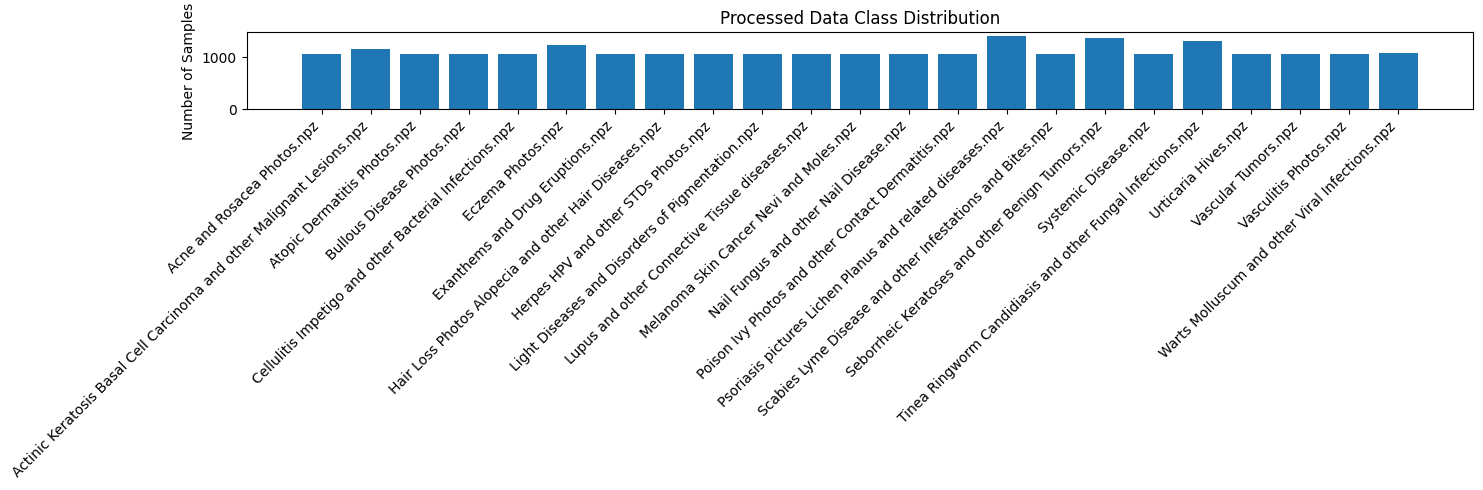


Processed Data Statistics:
Max class size: 1405
Min class size: 1063
Mean class size: 1113.78
Median class size: 1063.0

Verifying processed images...
Verifying images from class: Acne and Rosacea Photos.npz


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1500x300 with 5 Axes>


Verification Summary:
Image shape: (1063, 224, 224, 3)
Data type: float16
Value range: [-3.00, 3.00]

Preprocessing pipeline completed successfully!
Processed data saved to: /content/drive/MyDrive/dataset/SkinDisease/processed_data

Summary of processing:
1. Applied specialized preprocessing based on skin condition type
2. Performed class balancing with adaptive augmentation
3. Enhanced image quality with multiple techniques
4. Validated processed data
5. Saved preprocessing metadata


In [23]:
def validate_class_balance(config):
    """Validate the class balance after preprocessing"""
    train_dir = os.path.join(config.processed_dir, 'train_balanced')
    class_sizes = {}

    print("\nValidating class balance...")
    for file in os.listdir(train_dir):
        if file.endswith('.npz'):
            loaded_data = np.load(os.path.join(train_dir, file))
            data = loaded_data['data']
            class_sizes[file] = len(data)
            print(f"{file}: {len(data)} samples")

    plt.figure(figsize=(15, 5))
    plt.bar(class_sizes.keys(), class_sizes.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Processed Data Class Distribution')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

    print("\nProcessed Data Statistics:")
    print(f"Max class size: {max(class_sizes.values())}")
    print(f"Min class size: {min(class_sizes.values())}")
    print(f"Mean class size: {np.mean(list(class_sizes.values())):.2f}")
    print(f"Median class size: {np.median(list(class_sizes.values()))}")

def verify_images(config):
    """Verify processed images visually"""
    train_dir = os.path.join(config.processed_dir, 'train_balanced')
    class_files = sorted([f for f in os.listdir(train_dir) if f.endswith('.npz')])

    if not class_files:
        print("No processed images found for verification.")
        return

    # Load and display images from first class
    sample_class = class_files[0]
    print(f"Verifying images from class: {sample_class}")

    # Load from npz file
    loaded_data = np.load(os.path.join(train_dir, sample_class))
    images = loaded_data['data']

    # Display 5 sample images
    plt.figure(figsize=(15, 3))
    for i in range(min(5, len(images))):
        plt.subplot(1, 5, i+1)
        # Denormalize for display
        img = images[i]
        if img.dtype == np.float16 or img.dtype == np.float32:
            img = (img + 1) / 2  # Denormalize if using preprocessed data
            img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"\nVerification Summary:")
    print(f"Image shape: {images.shape}")
    print(f"Data type: {images.dtype}")
    print(f"Value range: [{images.min():.2f}, {images.max():.2f}]")

def main():
    try:
        print("Starting enhanced preprocessing pipeline...")

        # Mount Google Drive
        drive.mount('/content/drive')

        # Initialize configuration
        config = Config()
        config.create_directories()

        # Plot initial distribution
        print("\nAnalyzing initial class distribution...")
        plot_class_distributions(config.train_dir, config.test_dir)

        # Initialize preprocessor
        processor = ImageProcessor(config)

        # Process and save training data with balancing
        print("\nProcessing training data...")
        train_output_dir = os.path.join(config.processed_dir, 'train_balanced')
        processor.process_and_save(config.train_dir, train_output_dir, balance=True)

        # Process and save test data without balancing
        print("\nProcessing test data...")
        test_output_dir = os.path.join(config.processed_dir, 'test')
        processor.process_and_save(config.test_dir, test_output_dir, balance=False)

        # Validate processed data
        print("\nValidating processed data...")
        validate_class_balance(config)

        # Verify sample images
        print("\nVerifying processed images...")
        verify_images(config)

        # Save processing metadata
        metadata = {
            'image_size': config.image_size,
            'preprocessing_steps': [
                'normalize_image',
                'enhance_contrast',
                'normalize_color',
                'enhance_texture',
                'enhance_red_channel'
            ],
            'augmentation_techniques': [
                'rotation',
                'width_shift',
                'height_shift',
                'zoom',
                'horizontal_flip',
                'brightness_adjustment',
                'mixup'
            ]
        }

        with open(os.path.join(config.processed_dir, 'preprocessing_metadata.txt'), 'w') as f:
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")

        print("\nPreprocessing pipeline completed successfully!")
        print(f"Processed data saved to: {config.processed_dir}")
        print("\nSummary of processing:")
        print("1. Applied specialized preprocessing based on skin condition type")
        print("2. Performed class balancing with adaptive augmentation")
        print("3. Enhanced image quality with multiple techniques")
        print("4. Validated processed data")
        print("5. Saved preprocessing metadata")

    except Exception as e:
        print(f"\nError in preprocessing pipeline: {str(e)}")
        traceback.print_exc()
        raise

if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Enable memory logging
    import logging
    logging.basicConfig(level=logging.INFO)

    # Run main processing pipeline
    main()